# Time and space

Some necessary imports

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import re

Method for reading the lexicon size csv data

In [2]:
def read_lexicon_size(path, filename):
    file = path + filename + ".csv"
    with open(file) as f:
        data = pd.read_csv(f)
    return data

Method for parsing one line of the time.txt files

In [3]:
def parse_line(line):
    result = []
    # Line starts with time taken. Format is then: "Time taken\txxxxxxxxx"
    if(line.startswith("Time taken")):
        result.append("Time")
        time_taken = line.split("\t")
        time_hours_minutes = time_taken[1].split(", ")
        # xxxxxxxxx is in hours, minutes
        if(len(time_hours_minutes) > 1):
            time_total = [element.split(" ") for element in time_hours_minutes]
            result.append(str((int(time_total[0][0]) * 60 + int(time_total[1][0]))))
        # xxxxxxxxx is only in hours, or only in minutes
        else:
            time_total = time_hours_minutes[0].split(" ")
            if(time_total[1].startswith("hour")):
                result.append(str(int(time_total[0]) * 60))
            else:
                result.append(str(int(time_total[0])))
    # Line starts with Avg. per pair. Format is then "Avg. per pair\tx.xx minutes"
    elif(line.startswith("Avg. per pair")):
        result.append("Average")
        average_time_line = line.split("\t")
        average_time = average_time_line[1].split(" ")
        result.append(average_time[0])
    # Result is either ["Time", "total_time_in_minutes"]
    # or result is ["Average", "average_in_minutes"]
    return result

Some methods and list comprehension to parse all the time.txt files and the parameters stored in the data locations

In [4]:
# List of all titles and locations
hlc_rsa_model_title_list = ["_a5_b5.0_d0.5_f0_n0.0",   "_a100_b5.0_d0.5_f0_n0.5", "_a500_b5.0_d0.5_f0_n0.7", "_a500_b5.0_d0.5_f0_n0.9", 
                            "_a100_b5.0_d0.5_f1_n0.0", "_a100_b5.0_d0.5_f1_n0.5", "_a500_b5.0_d0.5_f1_n0.7", "_a500_b5.0_d0.5_f1_n0.9", 
                            "_a100_b5.0_d0.5_f2_n0.0", "_a100_b5.0_d0.5_f2_n0.5", "_a500_b5.0_d0.5_f2_n0.7", "_a100_b5.0_d0.5_f2_n0.9", 
                            "_a100_b5.0_d0.5_f3_n0.0", "_a500_b5.0_d0.5_f3_n0.5", "_a500_b5.0_d0.5_f3_n0.7", "_a500_b5.0_d0.5_f3_n0.9"]
hlc_rsa_model_location = "data/S4R3"

# Dictionary for renaming the codelike parameters to meaningful descriptions
dictionary_to_rename_parameters = {
    "a": "Agents",
    "b": "Alpha",
    "d": "X",
    "f": "Facts",
    "n": "Neighborliness",
}

# Looks up the codelike character in the dictionary and replaces that with the descriptive word
def make_human_readable(parameter):
    parameter[0] = dictionary_to_rename_parameters[parameter[0]]
    return parameter

# Splits the parameter string in letters and number. ('a500' becomes 'a', '500')
def split_parameter_string(parameters):
    return [(re.split('(\d.*)', level)[:-1]) for level in parameters]

# Replaces the single letters with the descriptive words
def readable_string(parameters):
    return [make_human_readable(level) for level in parameters]

# Split the title into the seperate parameters, using '_'. "_a500_b5" becomes "a500", "b5"
split_parameters_list = [title.split("_")[1:] for title in hlc_rsa_model_title_list]

# List comprehension that creates a list of lists that contain the names and values for the individual parameters
parameters_list = [readable_string(split_parameter_string(parameters)) for parameters in split_parameters_list]

Method to read a time.txt file

In [5]:
def read_time(path):
    filename = path + "Time" + ".txt"
    data = []
    with open(filename) as f:
        # Read only the 2nd and 3rd line, counting from 0.
        # These lines have the total time taken and the average per agent pair data in them
        for i, line in enumerate(f):
            if(i == 2 or i == 3):
                data.append(parse_line(line))
    return data

Reading of the times.txt files for each model run, combining them with the specific parameters for each run. Also reading the sizes of the lexicon search space for each combination of parameters.

In [6]:
times_parameters_list = [(read_time(hlc_rsa_model_location + title + "/"), parameters) for title, parameters in zip(hlc_rsa_model_title_list, parameters_list)]
lexicon_size_dataframe = read_lexicon_size("data/", "Lexicons_size")
lexicon_size_dataframe.sort_values(["Facts", "Neighborliness"], inplace=True)

Making one DataFrame of all the collected results

In [7]:
combined_list = []
for run, parameters in times_parameters_list:
    temp = []
    temp.append(parameters[3][1])
    temp.append(parameters[4][1])
    temp.append(run[1][1])
    combined_list.append(temp)

time_dataframe = pd.DataFrame(combined_list, columns=["Facts", "Neighborliness", "Average per pair"], dtype="float64")
df = pd.merge(lexicon_size_dataframe, time_dataframe)

Ceating the plots, first a scatterplot for facts and average per pair

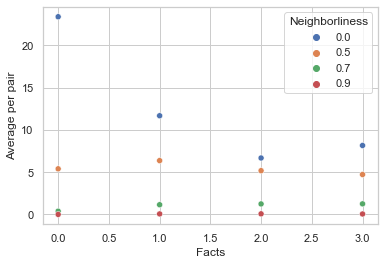

In [16]:
plt.figure()
s = sns.scatterplot(data=df, x="Facts", y="Average per pair", hue="Neighborliness", palette="deep")
#plt.savefig("images/scatter_2d_facts_average.jpg")

Then a scatterplot for neighborliness and average per pair

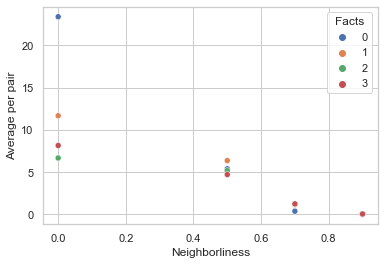

In [20]:
plt.figure()
s = sns.scatterplot(data=df, x="Neighborliness", y="Average per pair", hue="Facts", palette="deep")
#plt.savefig("images/scatter_2d_neighborliness_average.jpg")

Finally a 3D scatterplot to combine the two

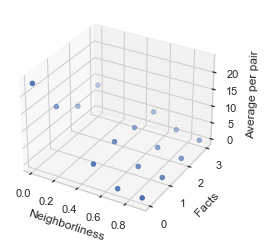

In [10]:
sns.set(style = "whitegrid")
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

n = "Neighborliness"
f = "Facts"
a = "Average per pair"

x = df[n]
y = df[f]
z = df[a]

ax.set_xlabel(n)
ax.set_ylabel(f)
ax.set_zlabel(a)

ax.scatter(x, y, z)
#plt.savefig("images/scatter_3d_facts_neighborliness_average.jpg", bbox_inches='tight', pad_inches=0)

Next I need scatterplots of the lexicon search space against the facts, neighborliness and a 3D version

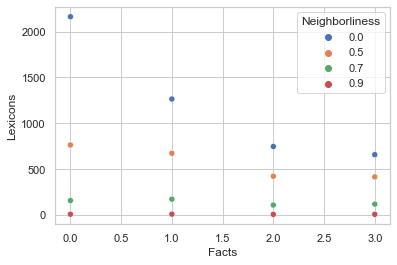

In [18]:
plt.figure()
s = sns.scatterplot(data=df, x="Facts", y="Neighborliness size", hue="Neighborliness", palette="deep")
s.set_ylabel("Lexicons")
#plt.savefig("images/scatter_2d_facts_size.jpg")

2D scatterplot for neighborliness against size

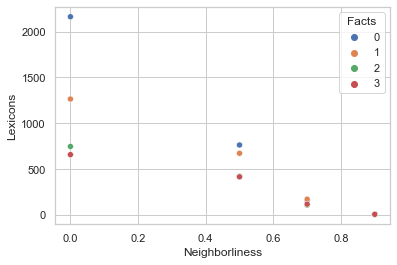

In [19]:
plt.figure()
s = sns.scatterplot(data=df, x="Neighborliness", y="Neighborliness size", hue="Facts", palette="deep")
s.set_ylabel("Lexicons")
#plt.savefig("images/scatter_2d_neighborliness_size.jpg")

And finally a 3D plot of neighborliness, facts and size

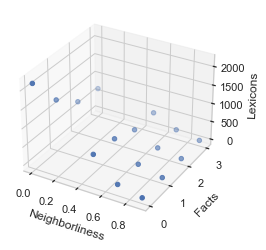

In [13]:
sns.set(style = "whitegrid")
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

n = "Neighborliness"
f = "Facts"
l = "Neighborliness size"

x = df[n]
y = df[f]
z = df[l]

ax.set_xlabel(n)
ax.set_ylabel(f)
ax.set_zlabel("Lexicons")

ax.scatter(x, y, z)
#plt.savefig("images/scatter_3d_facts_neighborliness_size.jpg", bbox_inches='tight', pad_inches=0)